# Category-Based Review Summarization with FLAN-T5

This notebook uses the rule-based categorized reviews to generate article-style summaries for products in each category. It leverages the FLAN-T5 model, which is an instruction-tuned version of T5 that performs well on text summarization tasks.

The goal is to create recommendation articles that highlight:
1. Top 3 products in each category and their key differences
2. Top complaints for each of those products
3. Worst product in each category and why it should be avoided

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from tqdm.notebook import tqdm
import os
from collections import defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

## 2. Load and Explore Data

In [4]:
# Load the rule-based categorized reviews
file_path = '/content/drive/MyDrive/RoboRev/Processed_data/final_categorized_reviews.csv'
reviews_df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {reviews_df.shape}")
reviews_df.head()

Dataset shape: (28332, 10)


,reviews.text,cleaned_text,name,categories,sentiment_label,sentiment_score,reviews.rating,rating_sentiment,mapped_sentiment,product_category
0,I order 3 of them and one of the item is bad q...,i order 3 of them and one of the item is bad q...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_0,0.902380,3,Neutral,Negative,Accessories
1,Bulk is always the less expensive way to go fo...,bulk is always the less expensive way to go fo...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_1,0.697489,4,Positive,Neutral,Accessories
2,Well they are not Duracell but for the price i...,well they are not duracell but for the price i...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.890748,5,Positive,Positive,Accessories
3,Seem to work as well as name brand batteries a...,seem to work as well as name brand batteries a...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.938524,5,Positive,Positive,Accessories
4,These batteries are very long lasting the pric...,these batteries are very long lasting the pric...,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",LABEL_2,0.965138,5,Positive,Positive,Accessories


Distribution of reviews across categories:
Accessories: 14097 reviews (49.8%)
E-readers: 6350 reviews (22.4%)
Smart Home & Speakers: 4266 reviews (15.1%)
Tablets & Entertainment: 3619 reviews (12.8%)


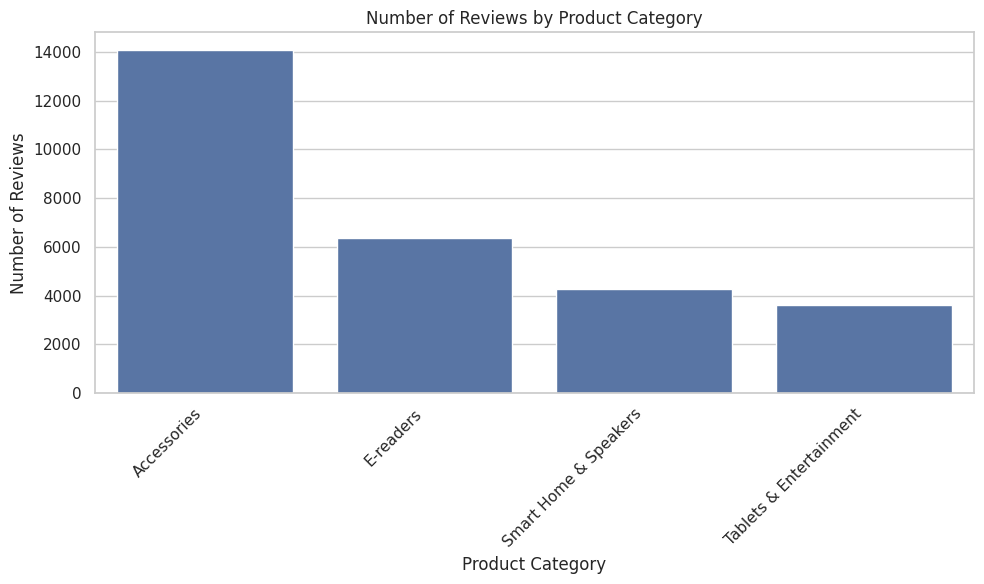

In [5]:
# Check the distribution of reviews across categories
category_counts = reviews_df['product_category'].value_counts()
print("Distribution of reviews across categories:")
for category, count in category_counts.items():
    print(f"{category}: {count} reviews ({count/len(reviews_df)*100:.1f}%)")

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Number of Reviews by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Prepare Data for Summarization RATING

In [6]:
# Calculate average rating for each product
product_ratings = reviews_df.groupby('name')['reviews.rating'].mean().reset_index()
product_ratings = product_ratings.rename(columns={'reviews.rating': 'avg_rating'})

# Count the number of reviews for each product
product_review_counts = reviews_df.groupby('name').size().reset_index(name='review_count')

# Create a product dataframe with category information
product_df = reviews_df[['name', 'product_category']].drop_duplicates()
product_df = product_df.merge(product_ratings, on='name', how='left')
product_df = product_df.merge(product_review_counts, on='name', how='left')

# Sort products by average rating within each category
product_df = product_df.sort_values(['product_category', 'avg_rating', 'review_count'],
                                    ascending=[True, False, False])

product_df.head(10)

,name,product_category,avg_rating,review_count
12,Expanding Accordion File Folder Plastic Portab...,Accessories,5.000000,9
21,AmazonBasics USB 3.0 Cable - A-Male to B-Male ...,Accessories,5.000000,6
13,Cat Litter Box Covered Tray Kitten Extra Large...,Accessories,5.000000,2
22,Two Door Top Load Pet Kennel Travel Crate Dog ...,Accessories,5.000000,1
27,AmazonBasics Nespresso Pod Storage Drawer - 50...,Accessories,5.000000,1
43,AmazonBasics Single-Door Folding Metal Dog Cra...,Accessories,5.000000,1
14,Amazon 9W PowerFast Official OEM USB Charger a...,Accessories,4.666667,39
17,Amazon Kindle Charger Power Adapter Wall Charg...,Accessories,4.666667,9
46,"All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...",Accessories,4.641638,293
47,"All-New Fire HD 8 Kids Edition Tablet, 8 HD Di...",Accessories,4.630901,233


In [7]:
# Display the top and bottom products in each category
for category in product_df['product_category'].unique():
    category_products = product_df[product_df['product_category'] == category]

    # Filter products with at least 3 reviews for more reliable ratings
    category_products_filtered = category_products[category_products['review_count'] >= 3]

    if len(category_products_filtered) > 0:
        # Use filtered products if available, otherwise use all products
        display_products = category_products_filtered
    else:
        display_products = category_products

    print(f"\n{'='*50}")
    print(f"Category: {category}")
    print(f"{'='*50}")

    # Top 3 products
    print(f"\nTop 3 products in {category}:")
    top_products = display_products.head(3)
    for i, (name, rating, count) in enumerate(zip(top_products['name'],
                                                top_products['avg_rating'],
                                                top_products['review_count']), 1):
        print(f"{i}. {name} (Average Rating: {rating:.2f}, Reviews: {count})")

    # Bottom product
    print(f"\nLowest rated product in {category}:")
    bottom_product = display_products.iloc[-1]
    print(f"{bottom_product['name']} (Average Rating: {bottom_product['avg_rating']:.2f}, Reviews: {bottom_product['review_count']})")


Category: Accessories

Top 3 products in Accessories:
1. Expanding Accordion File Folder Plastic Portable Document Organizer Letter Size (Average Rating: 5.00, Reviews: 9)
2. AmazonBasics USB 3.0 Cable - A-Male to B-Male - 6 Feet (1.8 Meters) (Average Rating: 5.00, Reviews: 6)
3. Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders (Average Rating: 4.67, Reviews: 39)

Lowest rated product in Accessories:
Oem Amazon Kindle Power Usb Adapter Wall Travel Charger Fire/dx/+micro Usb Cable (Average Rating: 1.00, Reviews: 4)

Category: E-readers

Top 3 products in E-readers:
1. Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Free 3G + Wi-Fi - Includes Special Offers (Average Rating: 4.89, Reviews: 36)
2. Kindle PowerFast International Charging Kit (for accelerated charging in over 200 countries) (Average Rating: 4.80, Reviews: 5)
3. All-New Kindle Oasis E-reader - 7 High-Resolution Dis

## 4. Load FLAN-T5 Summarization Model

In [8]:
model_name = "google/flan-t5-base"  # Options: small, base, large, xl, xxl
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using device: cuda


## 5. Define Summarization Functions

In [9]:
# Function to summarize text using FLAN-T5 with specific prompts
def summarize_with_flan_t5(text, prompt_type, product_name=None, category=None, sentiment=None, tone="formal", max_length=150): #added sentiment and tone, to see if it will help with the quality.
    # Check if text is too short
    if len(text.split()) < 20:
        return text

    try:
        # Create a specific prompt based on the prompt_type
        if prompt_type == "positive_features":
            prompt = f"Summarize the key positive features of {product_name} based on these reviews: {text}"
        elif prompt_type == "negative_features":
            prompt = f"Summarize the main complaints and issues with {product_name} based on these reviews: {text}"
        elif prompt_type == "product_comparison":
            prompt = f"Compare these top products in the {category} category and highlight their key differences: {text}"
        elif prompt_type == "avoid_reasons":
            prompt = f"Explain why customers should avoid {product_name} based on these negative reviews: {text}"
        elif prompt_type == "category_overview":
            prompt = f"Write a brief introduction about {category} products based on these reviews: {text}"
        else:
            # Generic prompt
            prompt = f"Summarize: {text}"

        # Encode the text
        input_ids = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids,
            max_length=max_length,
            min_length=30,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )

        # Decode the summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary
    except Exception as e:
        print(f"Summarization error: {e}")
        # Return a simple extraction of the first few sentences as a fallback
        sentences = text.split('.')
        short_summary = '.'.join(sentences[:3]) + '.'
        return short_summary

In [10]:
# Function to prepare reviews for summarization
def prepare_reviews_for_summarization(reviews_list, max_reviews=20, max_chars=5000):
    # Limit number of reviews
    if len(reviews_list) > max_reviews:
        reviews_list = reviews_list[:max_reviews]

    # Join reviews with separator
    combined_text = ". ".join(reviews_list)

    # Truncate if too long
    if len(combined_text) > max_chars:
        combined_text = combined_text[:max_chars]

    return combined_text

## 6. Generate Summaries for Each Category

In [15]:
# Create a directory to store the generated articles
output_dir = 'product_recommendation_articles'
os.makedirs(output_dir, exist_ok=True)

# Function to generate an article for a category
def generate_category_article(category, top_n=3):
    print(f"Generating article for {category}...")

    # Filter products for this category
    category_products = product_df[product_df['product_category'] == category]

    # Filter products with at least 3 reviews for more reliable ratings
    category_products_filtered = category_products[category_products['review_count'] >= 3]

    if len(category_products_filtered) >= top_n + 1:  # Need at least top_n + 1 for worst product
        # Use filtered products if available
        display_products = category_products_filtered
    else:
        # Use all products if not enough filtered products
        display_products = category_products

    # Get top products
    display_products_sorted = display_products.sort_values(by='avg_rating', ascending=False)
    top_products = display_products_sorted.head(top_n)


    # Get worst product (lowest rated)
    worst_product = display_products_sorted.tail(1).iloc[0]

    # Initialize article sections
    article_sections = {}

    # 1. Generate category overview
    all_category_reviews = reviews_df[reviews_df['product_category'] == category]['reviews.text'].tolist()
    category_reviews_text = prepare_reviews_for_summarization(all_category_reviews, max_reviews=30)
    article_sections['overview'] = summarize_with_flan_t5(
        category_reviews_text,
        prompt_type="category_overview",
        category=category,
        max_length=200
    )

    # 2. Generate summaries for top products
    top_product_summaries = []
    for _, product in top_products.iterrows():
        product_name = product['name']

        # Get positive reviews for this product
        positive_reviews = reviews_df[
            (reviews_df['name'] == product_name) &
            (reviews_df['mapped_sentiment'] == 'Positive')
        ]['reviews.text'].tolist()

        # Get negative reviews for this product
        negative_reviews = reviews_df[
            (reviews_df['name'] == product_name) &
            (reviews_df['mapped_sentiment'] == 'Negative')
        ]['reviews.text'].tolist()

        # Prepare review texts
        positive_text = prepare_reviews_for_summarization(positive_reviews)
        negative_text = prepare_reviews_for_summarization(negative_reviews)

        # Generate summaries
        positive_summary = summarize_with_flan_t5(
            positive_text,
            prompt_type="positive_features",
            product_name=product_name
        ) if positive_reviews else "No positive reviews available."

        negative_summary = summarize_with_flan_t5(
            negative_text,
            prompt_type="negative_features",
            product_name=product_name
        ) if negative_reviews else "No negative reviews available."

        # Store summaries
        top_product_summaries.append({
            'name': product_name,
            'rating': product['avg_rating'],
            'review_count': product['review_count'],
            'positive_summary': positive_summary,
            'negative_summary': negative_summary
        })

    article_sections['top_products'] = top_product_summaries

    # 3. Generate product comparison
    top_product_names = [p['name'] for p in top_product_summaries]
    comparison_text = "\n".join([f"{p['name']}: {p['positive_summary']} However, {p['negative_summary']}"
                               for p in top_product_summaries])

    article_sections['comparison'] = summarize_with_flan_t5(
        comparison_text,
        prompt_type="product_comparison",
        category=category,
        max_length=250
    )

    # 4. Generate worst product summary
    worst_product_name = worst_product['name']
    worst_product_reviews = reviews_df[
        (reviews_df['name'] == worst_product_name) &
        (reviews_df['mapped_sentiment'] == 'Negative')
    ]['reviews.text'].tolist()

    worst_text = prepare_reviews_for_summarization(worst_product_reviews)

    article_sections['worst_product'] = {
        'name': worst_product_name,
        'rating': worst_product['avg_rating'],
        'review_count': worst_product['review_count'],
        'avoid_reasons': summarize_with_flan_t5(
            worst_text,
            prompt_type="avoid_reasons",
            product_name=worst_product_name
        ) if worst_product_reviews else "Insufficient negative reviews to determine why this product should be avoided."
    }

    # Format the article
    article = format_article(category, article_sections)

    # Save the article
    filename = f"{output_dir}/{category.replace(' & ', '_').replace(' ', '_')}_recommendation.md"
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(article)

    print(f"Article saved to {filename}")

    return article

In [16]:
# Function to format the article in markdown
def format_article(category, article_sections):
    article = f"# Top {category} Products: A Comprehensive Guide\n\n"

    # Add overview
    article += f"## Overview\n\n{article_sections['overview']}\n\n"

    # Add top products section
    article += f"## Top 3 {category} Products\n\n"
    article += f"{article_sections['comparison']}\n\n"

    # Add detailed product reviews
    article += f"## Detailed Product Reviews\n\n"

    for i, product in enumerate(article_sections['top_products'], 1):
        article += f"### {i}. {product['name']}\n\n"
        article += f"**Average Rating:** {product['rating']:.2f} ({product['review_count']} reviews)\n\n"
        article += f"**What Customers Love:**\n{product['positive_summary']}\n\n"
        article += f"**Common Complaints:**\n{product['negative_summary']}\n\n"

    # Add worst product section
    worst = article_sections['worst_product']
    article += f"## Product to Avoid: {worst['name']}\n\n"
    article += f"**Average Rating:** {worst['rating']:.2f} ({worst['review_count']} reviews)\n\n"
    article += f"**Why You Should Avoid It:**\n{worst['avoid_reasons']}\n\n"

    # Add conclusion
    article += f"## Conclusion\n\n"
    article += f"When shopping for {category} products, our analysis shows that "
    article += f"the top three options offer excellent value and features. "
    article += f"The {article_sections['top_products'][0]['name']} stands out as the best overall choice, "
    article += f"while you may want to avoid the {worst['name']} due to the issues mentioned above. "
    article += f"Consider your specific needs and budget when making your final decision.\n"

    return article

In [17]:
# Generate articles for each category
all_categories = product_df['product_category'].unique()

for category in all_categories:
    generate_category_article(category)

Generating article for Accessories...
Article saved to product_recommendation_articles/Accessories_recommendation.md
Generating article for E-readers...
Article saved to product_recommendation_articles/E-readers_recommendation.md
Generating article for Smart Home & Speakers...
Article saved to product_recommendation_articles/Smart_Home_Speakers_recommendation.md
Generating article for Tablets & Entertainment...
Article saved to product_recommendation_articles/Tablets_Entertainment_recommendation.md


## 7. Display Sample Article

In [18]:
# Display a sample article
sample_category = all_categories[0]
filename = f"{output_dir}/{sample_category.replace(' & ', '_').replace(' ', '_')}_recommendation.md"

try:
    with open(filename, 'r', encoding='utf-8') as f:
        sample_article = f.read()
    print(sample_article)
except FileNotFoundError:
    print(f"Article file {filename} not found. Please run the generation cell first.")

# Top Accessories Products: A Comprehensive Guide

## Overview

AmazonBasics AA AAA batteries have done well by me appear to have a good shelf life. I haven't noticed a difference between the brand name batteries and the Amazon Basic brand. Just a lot easier to purchase and have arrived at the house and have on hand. Will buy again..

## Top 3 Accessories Products

Best kindle charger ever. Took 30 minutes to being my kindle back to life. However, I bought this because the package said it was a fast charger only to find it charges at normal speed... That was disappointing. I'm pretty sure I'm not doing anything wrong.

## Detailed Product Reviews

### 1. Expanding Accordion File Folder Plastic Portable Document Organizer Letter Size

**Average Rating:** 5.00 (9 reviews)

**What Customers Love:**
This folder also expands on the bottom. Will allow A LOT more than when the bottom does not expand. Bought a second. I recommend this to my friends..

**Common Complaints:**
No negative reviews

## 8. Conclusion

In this notebook, we've successfully:

1. Loaded and explored the rule-based categorized reviews dataset
2. Identified top and worst products in each category
3. Used the FLAN-T5 model to generate summaries of positive and negative aspects of each product
4. Created comprehensive recommendation articles for each product category
5. Saved these articles as markdown files for easy reading and sharing

These generated articles provide valuable insights for consumers looking to make informed purchasing decisions in each product category.